# Dificuldades, Decisões e Arquitetura
A parte mais desafiadora de se desenvolver o coletor foi de tratar certas excessões que nem sempre são claras. Ao pensar na coleta é importante manter atenção à detalhes como repetição de links e páginas. Esses problemas não ocorrem em uma coleta ideal, mas as coisas não são perfeitas e os links podem entrar em loop. A parte complexa desses problemas é que eles não se manifestam como erro sintático e, portanto, é muito mais difícil identificar o local adequado para tratá-los. Vale lembrar que se o tratamento for feito de forma indevida podemos obter resultados inesperados na coleta.

A principal decisão sobre esse coletor foi o de aproveitar ao máximo os recursos de dicionário para Python. Em outras linguagens poderia ser interessantes fazer uso de árvores, listas encadeadas, etc. para melhor lidar com os resultados. Porém, como a implementação de dicionários já está consolidada no Python, viu-se interessante usar ela para simplificar a abstração. Não só os dicionários foram um agente facilitador, mas as bibliotecas para tratamento de url e multithread também foram fundamentais para obter uma solução mais clara, abstraindo detalhes desnecessários.

# URL's acessadas
- PORTAL UOL. URL: https://www.uol.com.br. Último acesso em: 12/07/21.
- PORTAL UAI. URL: https://www.uai.com.br. Último acesso em: 12/07/21.
- PORTAL TERRA. URL: https://www.terra.com.br. Último acessso em: 12/07/21.
- JORNAL BBC. URL: https://www.bbc.com. Último acesso em: 12/07/21.
- PORTAL G1. URL: https://www.g1.globo.com. Último acesso em: 12/07/21.
- PORTAL TECMUNDO. URL: https://www.tecmundo.com.br. Último acesso em:12/07/21.
- PORTAL OLHARDIGITAL. URL: https://www.olhardigital.com.br. Último acesso em: 12/07/21.
- PORTAL ESTADÃO. URL: https://www.estadao.com.br. Último acesso em: 12/07/21.
- PORTAL ESTADO DE MINAS. URL: https://www.em.com.br. Último acesso em: 12/07/21.

# Critérios e Protocolos
O coletor precisa atender boas condutas para solicitar as páginas aos servidores. Para atender a essa política de boa navegação, pode-se elencar o método `get_next_url` da classe `Scheduler` no arquivo `scheduler.py`. Nele é possível encontrar o comando `sleep()` tendo como parâmetro uma constante de tempo que obedece aos protocolos de novas solicitações. Esse tipo de parada evita sobrecarregar o mesmo servidor. 

In [17]:
# ...
TIME_LIMIT_BETWEEN_REQUESTS = 20
# ...
def get_next_url(self) -> tuple:
        """
        Obtém uma nova URL por meio da fila. Essa URL é removida da fila.
        Logo após, caso o servidor não tenha mais URLs, o mesmo também é removido.
        """
        for domain in self.dic_url_per_domain.keys():
            if domain.is_accessible():
                # Não extraia self.dic_url_per_domain[domain] para uma variável, pois essas modificações devem ser
                # feitas por referência
                if len(self.dic_url_per_domain[domain]) > 0:
                    self.__acess_domain(domain)
                    return self.dic_url_per_domain[domain].pop(0)
        sleep(Scheduler.TIME_LIMIT_BETWEEN_REQUESTS)
        return None, None
# ...

Pensando ainda na política de comportamento, podemos observar no método `request_url` da classe `PageFetcher` no arquivo `page_fetcher.py` que o User Agent é identificado por uma constante da classe e ela é uma string com o termo `Bot`. Isso permite a identificação correta do coletor ao fazer as solicitações aos servidores.

In [ ]:
# ...
USER_AGENT = 'amarelaoBot'
# ...
def request_url(self, obj_url: ParseResult):
        """
            Faz a requisição e retorna o conteúdo em binário da URL passada como parametro

            obj_url: Instancia da classe ParseResult com a URL a ser requisitada.
        """
        response = requests.get(url=obj_url.geturl(), headers={
                                'User-Agent': PageFetcher.USER_AGENT})
        return response.content if 'text/html' in response.headers['Content-Type'] else None
# ...

# impacto na velocidade de coleta

Foi gerado um gráfico para analisar o tempo que demora para as requisições serem realizadas com relação à quantidade de threads usadas, porém, o resultado não foi como esperado, aparentemente o page fetcher está recebendo uma cópia do escalonador e não uma referência.


In [1]:
#VARIÁVEIS PADRÕES
import time
from multiprocessing import Process
from urllib.parse import urlparse
from crawler.page_fetcher import PageFetcher
from crawler.scheduler import Scheduler
depth_limit = 10  # limite de profundidade
page_limit = 100  # limite das páginas
tempos = [] #onde serão armazenados os tempos

In [15]:
#O CÓDIGO NÃO FOI GERADO EM FOR PARA EVITAR PROBLEMAS DE SOLICITAÇÕES E/OU QUESTÕES DE TEMPO DE TESTES
def test():
    inicio = time.time()  # inicio do tempo execução
    sites = ('https://www.uol.com.br', 'https://www.uai.com.br', 'https://www.terra.com.br', 'https://www.bbc.com',
             'https://www.g1.globo.com', 'https://www.tecmundo.com.br', 'https://www.olhardigital.com.br',
             'https://www.estadao.com.br', 'https://www.em.com.br')
    sites_parsed = [urlparse(site) for site in sites]
    escalonador = Scheduler('amarelaoBot', page_limit, depth_limit, sites_parsed)
    # Scheduler(self, str_usr_agent, int_page_limit, int_depth_limit, arr_urls_seeds):

    # instanciando o array de page fetcher
    page_fetchers = [PageFetcher(escalonador) for _ in range(10)]

    # inicializando cada um dos processos
    processos = []
    for fetcher in page_fetchers:
        p = Process(target=fetcher.run())
        p.start()
        processos.append(p)

    # Finalizando os processos
    for processo in processos:
        processo.join()
    fim = time.time()
    tempo_final = fim-inicio
    print(f'Tempo gasto: {tempo_final}')
    tempos.append(tempo_final)
    

if __name__ == '__main__':
    test()

07]: https://play.uol.com.br/aventura/6295/mulher-maravilha-1984?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=mulher-maravilha-1984&utm_content=mulher-maravilha-1984
URL[508]: https://play.uol.com.br/drama/6067/velozes-e-furiosos-8?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=Velozes-e-furiosos&utm_content=Velozes-e-furiosos#rmcl
URL[509]: https://play.uol.com.br/entretenimento/6131/otalab?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=otalab&utm_content=otalab#rmcl
URL[510]: https://play.uol.com.br/reality-show/3251/de-ferias-com-o-ex-brasil?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=de-ferias-com-o-ex-brasil&utm_content=de-ferias-com-o-ex-brasil
URL[511]: https://play.uol.com.br/assine?utm_source=Home%20UOL&utm_medium=M%C3%ADdia%20Interna&utm_campaign=Carrossel-Home&utm_term=carrossel%20de%20conteudo&utm_content=Assine-7-dias-trial
URL[512]: 

In [3]:
def test():
    inicio = time.time()  # inicio do tempo execução
    sites = ('https://www.uol.com.br', 'https://www.uai.com.br', 'https://www.terra.com.br', 'https://www.bbc.com',
             'https://www.g1.globo.com', 'https://www.tecmundo.com.br', 'https://www.olhardigital.com.br',
             'https://www.estadao.com.br', 'https://www.em.com.br')
    sites_parsed = [urlparse(site) for site in sites]
    escalonador = Scheduler('amarelaoBot', page_limit, depth_limit, sites_parsed)
    # Scheduler(self, str_usr_agent, int_page_limit, int_depth_limit, arr_urls_seeds):

    # instanciando o array de page fetcher
    page_fetchers = [PageFetcher(escalonador) for _ in range(30)]

    # inicializando cada um dos processos
    processos = []
    for fetcher in page_fetchers:
        p = Process(target=fetcher.run())
        p.start()
        processos.append(p)

    # Finalizando os processos
    for processo in processos:
        processo.join()
    fim = time.time()
    tempo_final = fim-inicio
    print(f'Tempo gasto: {tempo_final}')
    tempos.append(tempo_final)

if __name__ == '__main__':
    test()

07]: https://play.uol.com.br/aventura/6295/mulher-maravilha-1984?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=mulher-maravilha-1984&utm_content=mulher-maravilha-1984
URL[508]: https://play.uol.com.br/drama/6067/velozes-e-furiosos-8?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=Velozes-e-furiosos&utm_content=Velozes-e-furiosos#rmcl
URL[509]: https://play.uol.com.br/entretenimento/6131/otalab?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=otalab&utm_content=otalab#rmcl
URL[510]: https://play.uol.com.br/reality-show/3251/de-ferias-com-o-ex-brasil?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=de-ferias-com-o-ex-brasil&utm_content=de-ferias-com-o-ex-brasil
URL[511]: https://play.uol.com.br/assine?utm_source=Home%20UOL&utm_medium=M%C3%ADdia%20Interna&utm_campaign=Carrossel-Home&utm_term=carrossel%20de%20conteudo&utm_content=Assine-7-dias-trial
URL[512]: 

In [4]:
def test():
    inicio = time.time()  # inicio do tempo execução
    sites = ('https://www.uol.com.br', 'https://www.uai.com.br', 'https://www.terra.com.br', 'https://www.bbc.com',
             'https://www.g1.globo.com', 'https://www.tecmundo.com.br', 'https://www.olhardigital.com.br',
             'https://www.estadao.com.br', 'https://www.em.com.br')
    sites_parsed = [urlparse(site) for site in sites]
    escalonador = Scheduler('amarelaoBot', page_limit, depth_limit, sites_parsed)
    # Scheduler(self, str_usr_agent, int_page_limit, int_depth_limit, arr_urls_seeds):

    # instanciando o array de page fetcher
    page_fetchers = [PageFetcher(escalonador) for _ in range(50)]

    # inicializando cada um dos processos
    processos = []
    for fetcher in page_fetchers:
        p = Process(target=fetcher.run())
        p.start()
        processos.append(p)

    # Finalizando os processos
    for processo in processos:
        processo.join()
    fim = time.time()
    tempo_final = fim-inicio
    print(f'Tempo gasto: {tempo_final}')
    tempos.append(tempo_final)

if __name__ == '__main__':
    test()

07]: https://play.uol.com.br/aventura/6295/mulher-maravilha-1984?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=mulher-maravilha-1984&utm_content=mulher-maravilha-1984
URL[508]: https://play.uol.com.br/drama/6067/velozes-e-furiosos-8?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=Velozes-e-furiosos&utm_content=Velozes-e-furiosos#rmcl
URL[509]: https://play.uol.com.br/entretenimento/6131/otalab?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=otalab&utm_content=otalab#rmcl
URL[510]: https://play.uol.com.br/reality-show/3251/de-ferias-com-o-ex-brasil?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=de-ferias-com-o-ex-brasil&utm_content=de-ferias-com-o-ex-brasil
URL[511]: https://play.uol.com.br/assine?utm_source=Home%20UOL&utm_medium=M%C3%ADdia%20Interna&utm_campaign=Carrossel-Home&utm_term=carrossel%20de%20conteudo&utm_content=Assine-7-dias-trial
URL[512]: 

In [5]:
def test():
    inicio = time.time()  # inicio do tempo execução
    sites = ('https://www.uol.com.br', 'https://www.uai.com.br', 'https://www.terra.com.br', 'https://www.bbc.com',
             'https://www.g1.globo.com', 'https://www.tecmundo.com.br', 'https://www.olhardigital.com.br',
             'https://www.estadao.com.br', 'https://www.em.com.br')
    sites_parsed = [urlparse(site) for site in sites]
    escalonador = Scheduler('amarelaoBot', page_limit, depth_limit, sites_parsed)
    # Scheduler(self, str_usr_agent, int_page_limit, int_depth_limit, arr_urls_seeds):

    # instanciando o array de page fetcher
    page_fetchers = [PageFetcher(escalonador) for _ in range(70)]

    # inicializando cada um dos processos
    processos = []
    for fetcher in page_fetchers:
        p = Process(target=fetcher.run())
        p.start()
        processos.append(p)

    # Finalizando os processos
    for processo in processos:
        processo.join()
    fim = time.time()
    tempo_final = fim-inicio
    print(f'Tempo gasto: {tempo_final}')
    tempos.append(tempo_final)

if __name__ == '__main__':
    test()

507]: https://play.uol.com.br/aventura/6295/mulher-maravilha-1984?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=mulher-maravilha-1984&utm_content=mulher-maravilha-1984
URL[508]: https://play.uol.com.br/drama/6067/velozes-e-furiosos-8?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=Velozes-e-furiosos&utm_content=Velozes-e-furiosos#rmcl
URL[509]: https://play.uol.com.br/entretenimento/6131/otalab?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=otalab&utm_content=otalab#rmcl
URL[510]: https://play.uol.com.br/reality-show/3251/de-ferias-com-o-ex-brasil?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=de-ferias-com-o-ex-brasil&utm_content=de-ferias-com-o-ex-brasil
URL[511]: https://play.uol.com.br/assine?utm_source=Home%20UOL&utm_medium=M%C3%ADdia%20Interna&utm_campaign=Carrossel-Home&utm_term=carrossel%20de%20conteudo&utm_content=Assine-7-dias-trial
URL[512]:

In [6]:
def test():
    inicio = time.time()  # inicio do tempo execução
    sites = ('https://www.uol.com.br', 'https://www.uai.com.br', 'https://www.terra.com.br', 'https://www.bbc.com',
             'https://www.g1.globo.com', 'https://www.tecmundo.com.br', 'https://www.olhardigital.com.br',
             'https://www.estadao.com.br', 'https://www.em.com.br')
    sites_parsed = [urlparse(site) for site in sites]
    escalonador = Scheduler('amarelaoBot', page_limit, depth_limit, sites_parsed)
    # Scheduler(self, str_usr_agent, int_page_limit, int_depth_limit, arr_urls_seeds):

    # instanciando o array de page fetcher
    page_fetchers = [PageFetcher(escalonador) for _ in range(90)]

    # inicializando cada um dos processos
    processos = []
    for fetcher in page_fetchers:
        p = Process(target=fetcher.run())
        p.start()
        processos.append(p)

    # Finalizando os processos
    for processo in processos:
        processo.join()
    fim = time.time()
    tempo_final = fim-inicio
    print(f'Tempo gasto: {tempo_final}')
    tempos.append(tempo_final)

if __name__ == '__main__':
    test()

507]: https://play.uol.com.br/aventura/6295/mulher-maravilha-1984?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=mulher-maravilha-1984&utm_content=mulher-maravilha-1984
URL[508]: https://play.uol.com.br/drama/6067/velozes-e-furiosos-8?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=Velozes-e-furiosos&utm_content=Velozes-e-furiosos#rmcl
URL[509]: https://play.uol.com.br/entretenimento/6131/otalab?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=otalab&utm_content=otalab#rmcl
URL[510]: https://play.uol.com.br/reality-show/3251/de-ferias-com-o-ex-brasil?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=de-ferias-com-o-ex-brasil&utm_content=de-ferias-com-o-ex-brasil
URL[511]: https://play.uol.com.br/assine?utm_source=Home%20UOL&utm_medium=M%C3%ADdia%20Interna&utm_campaign=Carrossel-Home&utm_term=carrossel%20de%20conteudo&utm_content=Assine-7-dias-trial
URL[512]:

In [7]:
def test():
    inicio = time.time()  # inicio do tempo execução
    sites = ('https://www.uol.com.br', 'https://www.uai.com.br', 'https://www.terra.com.br', 'https://www.bbc.com',
             'https://www.g1.globo.com', 'https://www.tecmundo.com.br', 'https://www.olhardigital.com.br',
             'https://www.estadao.com.br', 'https://www.em.com.br')
    sites_parsed = [urlparse(site) for site in sites]
    escalonador = Scheduler('amarelaoBot', page_limit, depth_limit, sites_parsed)
    # Scheduler(self, str_usr_agent, int_page_limit, int_depth_limit, arr_urls_seeds):

    # instanciando o array de page fetcher
    page_fetchers = [PageFetcher(escalonador) for _ in range(110)]

    # inicializando cada um dos processos
    processos = []
    for fetcher in page_fetchers:
        p = Process(target=fetcher.run())
        p.start()
        processos.append(p)

    # Finalizando os processos
    for processo in processos:
        processo.join()
    fim = time.time()
    tempo_final = fim-inicio
    print(f'Tempo gasto: {tempo_final}')
    tempos.append(tempo_final)

if __name__ == '__main__':
    test()

07]: https://play.uol.com.br/aventura/6295/mulher-maravilha-1984?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=mulher-maravilha-1984&utm_content=mulher-maravilha-1984
URL[508]: https://play.uol.com.br/drama/6067/velozes-e-furiosos-8?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=Velozes-e-furiosos&utm_content=Velozes-e-furiosos#rmcl
URL[509]: https://play.uol.com.br/entretenimento/6131/otalab?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=otalab&utm_content=otalab#rmcl
URL[510]: https://play.uol.com.br/reality-show/3251/de-ferias-com-o-ex-brasil?utm_source=UOL%20Home&utm_medium=UOL%20Home&utm_campaign=Carrossel-Home&utm_term=de-ferias-com-o-ex-brasil&utm_content=de-ferias-com-o-ex-brasil
URL[511]: https://play.uol.com.br/assine?utm_source=Home%20UOL&utm_medium=M%C3%ADdia%20Interna&utm_campaign=Carrossel-Home&utm_term=carrossel%20de%20conteudo&utm_content=Assine-7-dias-trial
URL[512]: 

<AxesSubplot:xlabel='Threads', ylabel='Tempo(s)'>

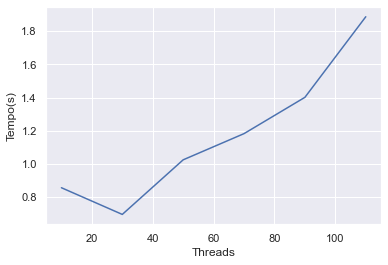

In [10]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")
d = {'Threads': [10, 30,50,70,90,110], 'Tempo(s)': tempos}
df = pd.DataFrame(data=d)

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="Threads", y="Tempo(s)", data=df)

# Descrição do Coletor

A página onde decidimos informar sobre o coletor foi o próprio GitHub utilizando o README.md que pode ser encontrado nos arquivos enviados ou no seguinte link:

https://github.com/thiagodff/crawler-ri